In [1]:
%%time
%run theory_basics.ipynb
from IPython.display import clear_output
clear_output()

CPU times: user 21.5 s, sys: 40 s, total: 1min 1s
Wall time: 10.6 s


In [2]:
from scipy.ndimage import zoom
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

In [3]:
def calculate_frequencies(indices, dt, signal_length):
    """Calculate and interpolate frequencies"""
    time_periods = np.diff(indices) * dt
    frequencies = 1 / time_periods
    midpoints = indices[:-1] + np.diff(indices) / 2
    f = interp1d(midpoints, frequencies, kind='linear', fill_value='extrapolate', bounds_error=False)
    return f(np.arange(signal_length))

def infer_frequencies(x, dt=1/N):
    """
    Assign current frequency at each timestep.
    
    Parameters:
       x(numpy.ndarray): input, continuous signal
       dt(float): time difference between each subsequent sample (1/Fs)
       
    Returns:
       numpy.ndarray: current frequency at each timestep
    """
    # Detect peaks and troughs
    peak_indices = find_peaks(x)[0]
    trough_indices = find_peaks(-x)[0]

    # Calculate frequencies using peaks and troughs independently
    peak_freqs = calculate_frequencies(peak_indices, dt, len(x))
    trough_freqs = calculate_frequencies(trough_indices, dt, len(x))

    # Combine the frequencies calculated from peaks and troughs
    combined_freqs = (peak_freqs + trough_freqs) / 2

    return combined_freqs

In [4]:
def get_angle(f):
    return np.angle(np.fft.fft(f)[1])

def get_angles(F):
    return np.angle(np.fft.fft(F, axis=1)[:, 1])

def get_amps(F):
    return np.abs(np.fft.fft(F, axis=1)[:, 1])

In [5]:
def to_theta(x):
    return ((x + np.pi) % (2*np.pi)) - np.pi

In [6]:
def mean_angle(amps, angs):
    s = sum(amps)
    return np.angle(np.sum([
        amp * np.exp(1j*ang)
        for amp, ang in zip(amps, angs)
    ], axis=0))

In [7]:
def get_dx(X, w, i, f_I, phi, u, alpha, theta, t, delay_i, T, dt, train=True):
    I_in = f_I(w, X[i - delay_i])
    return (-X[i - 1] + phi(int(train) * u(t[i] + theta, T) + I_in)) * dt * alpha

def f_I_conv_circ_fft(signal, ker):
    return np.real(np.fft.ifft(np.fft.fft(signal) * np.fft.fft(ker)))

# dreaming

### an explanation of phase shifting

In [8]:
simulation_duration = 150.5 * T
t = np.arange(0, simulation_duration, dt)

lmbda = 20

tau_x = 1 / 100
alpha = 1 / tau_x

tau_a = T / 3
delay_i = round(tau_a / dt)

tau_w = 50
beta = 1 / tau_w
#beta = 0

In [9]:
%%time
(
    X, w, W, DW, DX
) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_.copy(),
             get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
             train=False, full_info=True, init_stimulation=True)

CPU times: user 5.14 s, sys: 80.1 ms, total: 5.22 s
Wall time: 5.22 s


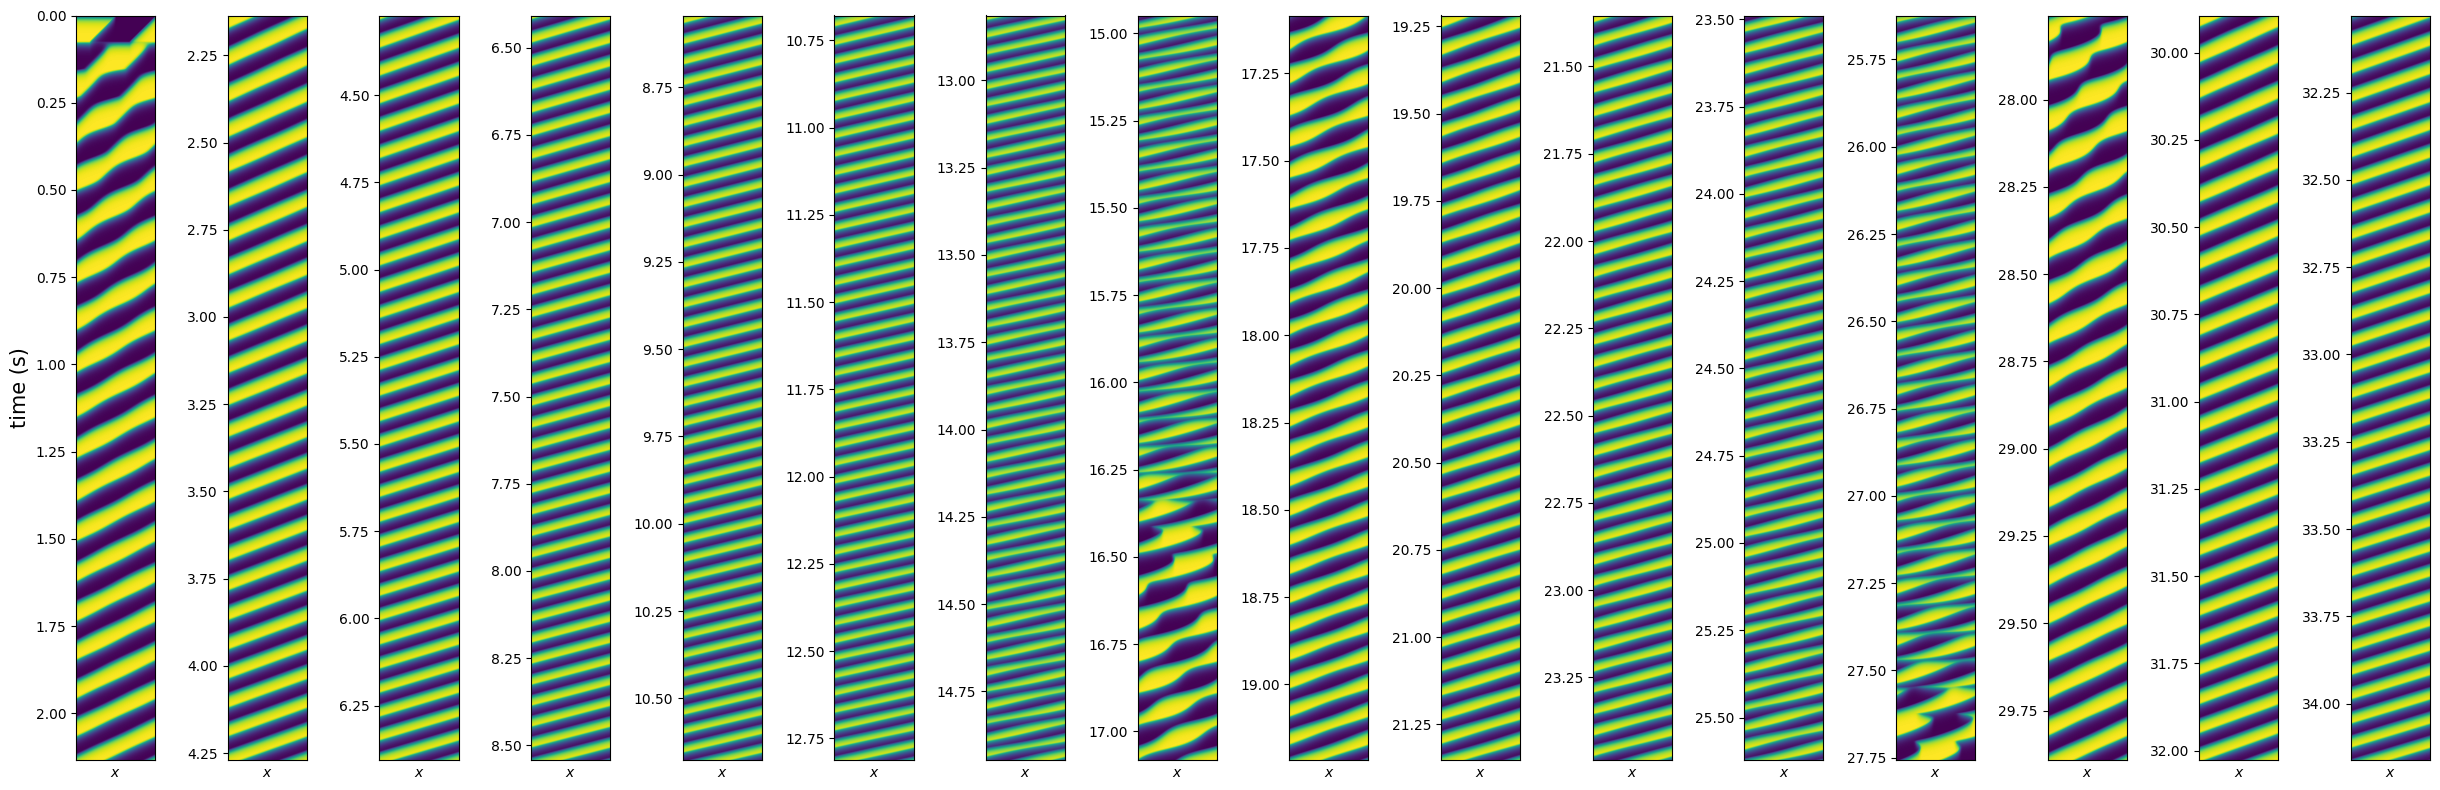

In [10]:
plot_activity(X, t, bins=16, cutoff_div=None)

In [118]:
def plot_system_segment(start, end, X, W, t):
    plt.figure(figsize=(12, 5))
    gs = plt.GridSpec(1, 4, width_ratios=[1, 2, 2, 0.1])
    ax1 = plt.subplot(gs[0, 0])
    ax1.imshow(X[start:end], extent=[0, N/(end-start)*(t[end]-t[start]), t[end], t[start]])
    ax1.set_ylabel('time (s)')
    ax1.set_xlabel('x')
    ax1.set_title(r'$r(x, t)$')
    ax2 = plt.subplot(gs[0, 1])
    X_fft = np.fft.fft(X, axis=1)[:, 1]
    ax2.scatter(X_fft.real[start:end], X_fft.imag[start:end], c=t[start:end], s=1)
    ax2.set_xlabel('Re')
    ax2.set_ylabel('Im')
    ax2.set_title(r'$\mathcal{F}_{x}[r](\xi=\frac{1}{T}, t)$')
    ax3 = plt.subplot(gs[0, 2])
    W_fft = np.fft.fft(W, axis=1)[:, 1]
    w_fft_max_h = np.abs(W_fft.real[start:end]).max()+5
    w_fft_max_v = np.abs(W_fft.imag[start:end]).max()+5
    w_fft_max = max(w_fft_max_h, w_fft_max_v)
    scatter = ax3.scatter(W_fft.real[start:end], W_fft.imag[start:end], c=t[start:end], s=1)
    ax3.set_xlim(-w_fft_max, w_fft_max)
    ax3.set_ylim(-w_fft_max, w_fft_max)
    ax3.set_xlabel('Re')
    ax3.set_ylabel('Im')
    ax3.set_title(r'$\mathcal{F}_{\Delta x}[w](\xi=\frac{1}{T}, t)$')
    ax_colorbar = plt.subplot(gs[0, -1])
    cbar = plt.colorbar(scatter, cax=ax_colorbar)
    cbar.set_label('time (s)')
    plt.tight_layout()
    plt.show()

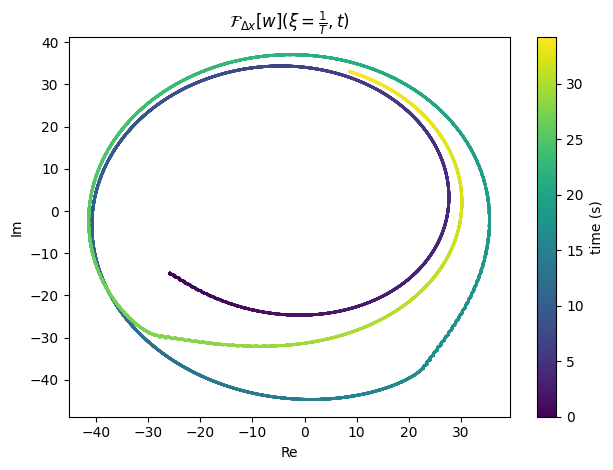

In [122]:
W_fft = np.fft.fft(W, axis=1)[:, 1]
scatter = plt.scatter(W_fft.real, W_fft.imag, c=t, s=1)
plt.title(r'$\mathcal{F}_{\Delta x}[w](\xi=\frac{1}{T}, t)$')
plt.xlabel('Re')
plt.ylabel('Im')
cbar = plt.colorbar(scatter)
cbar.set_label('time (s)')
plt.tight_layout()

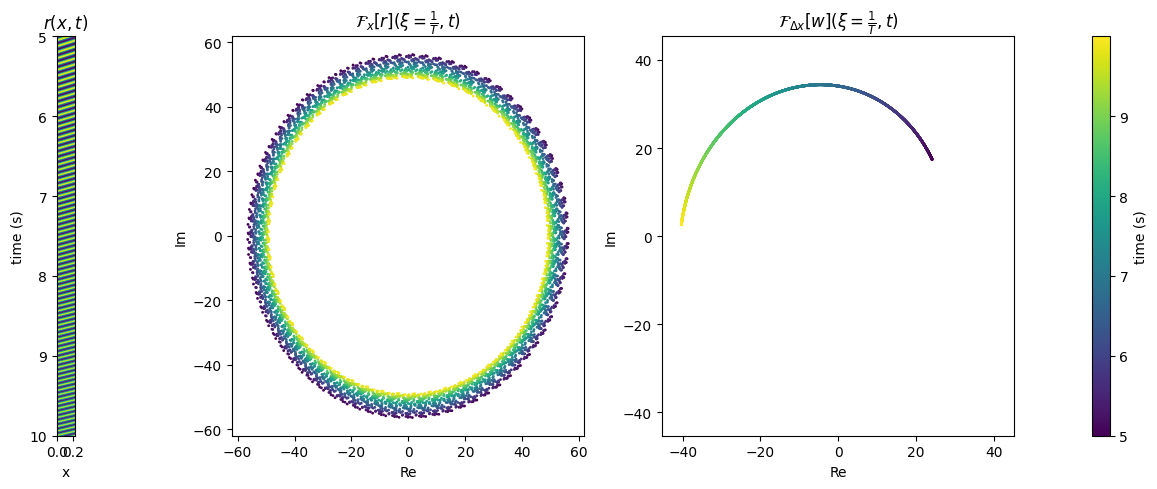

In [126]:
plot_system_segment(5000, 10000, X, W, t)

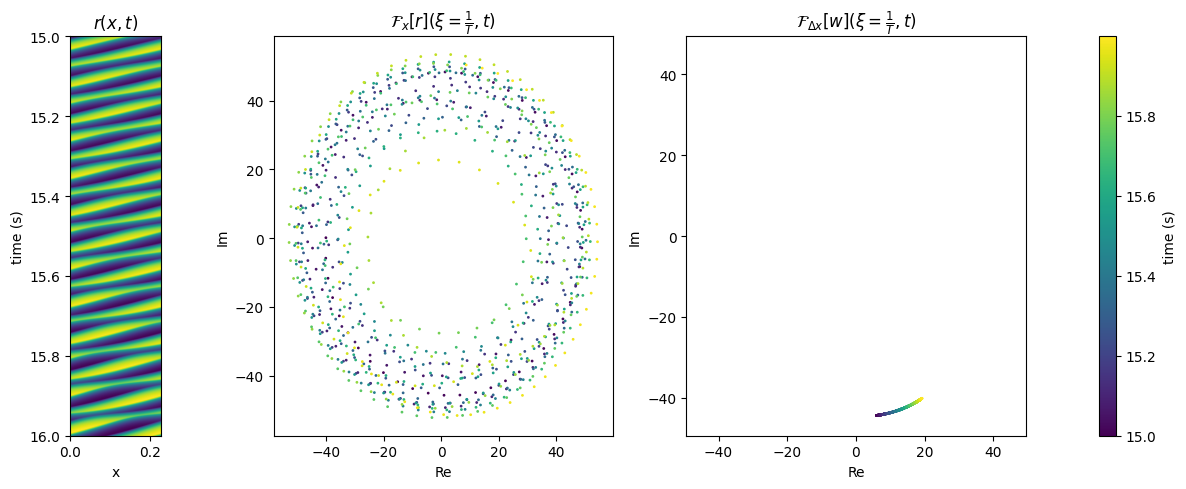

In [124]:
plot_system_segment(15000, 16000, X, W, t)

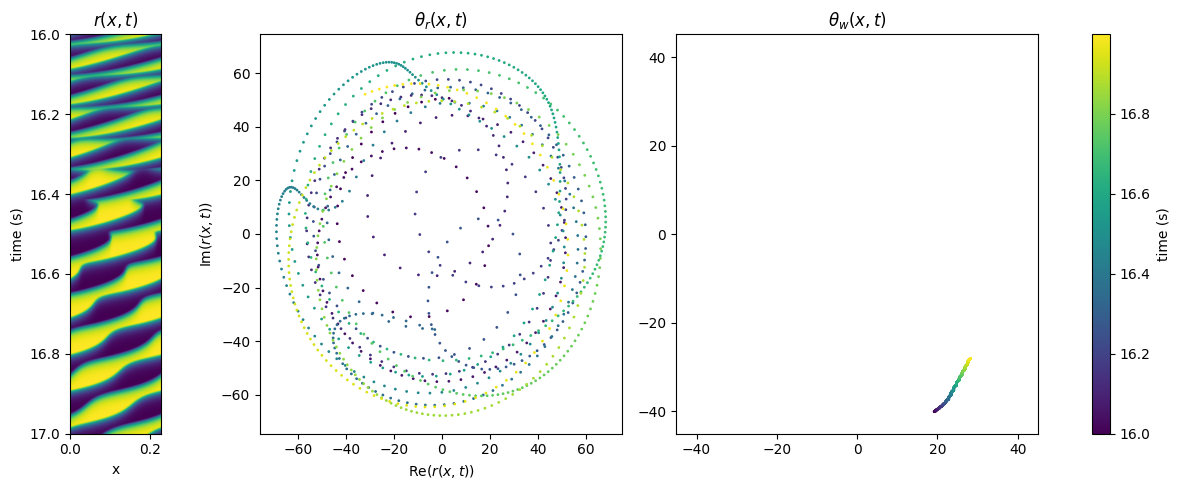

In [83]:
plot_system_segment(16000, 17000, X, W, t)

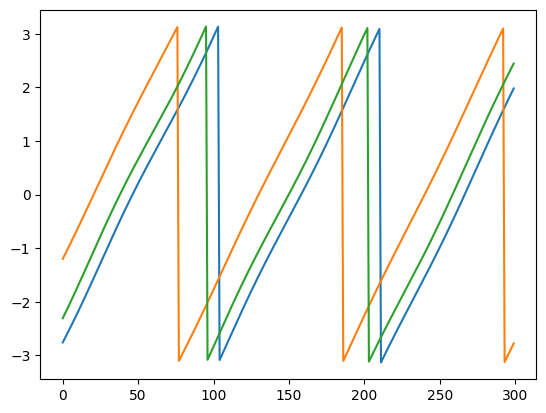

In [18]:
plt.plot(get_angles(X)[-300:])
plt.plot(get_angles(DX)[-300:])
plt.plot(get_angles(DX + dt*alpha*X[:-1])[-300:])

In [122]:
get_amps(X)[-500:].mean(), get_amps(DX)[-500:].mean(), get_amps(DX + dt*alpha*X[:-1])[-500:].mean()

(60.51295709578108, 4.48169354057176, 7.885693440521516)

In [123]:
get_amps(X)[-500:].var(), get_amps(DX)[-500:].var(), get_amps(DX + dt*alpha*X[:-1])[-500:].var()

(8.895826655996306e-29, 9.150786500563736e-31, 3.1081119665707865e-30)

first idea: describe in fourier space, look at phase of 1. component of w, and frequency of 1. component of r

shifted phase of w -> higher frequency of r

$$
\tau_r \frac{\partial}{\partial t} r(x, t) = -r(x, t) + \varphi\big([w(x', t)*{r}(x', t-\tau_d)](x)\big)
$$

$$
\tau_w\frac{\partial}{\partial t} w(\Delta x, t) = \frac{1}{T}[\dot{r}(x', t) *' r(x', t-\tau_d)](\Delta x) - \lambda {w}(\Delta x, t)
$$

$$
\mathcal{F}([{f}(x) *' {g}(x)](x)) = \mathcal{F}([{f}(-x) * {g}(x)](-x)) = \overline{\overline{\mathcal{F}[{f}(x)]} {\mathcal{F}[{g}(x)]}} = \mathcal{F}[{f}(x)] \overline{\mathcal{F}[{g}(x)]}
$$

$$
    \theta_{\dot{r}} = \text{arg}\Big(\mathcal{F}_{x}\Big[\frac{\partial}{\partial t} r\Big]\Big(\xi=\frac{1}{T}, t\Big)\Big) = \text{arg}\Big(-\mathcal{F}_{x}[r]\Big(\xi=\frac{1}{T}, t\Big) + \mathcal{F}_x[w(x, t)*{r}(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$

$$
\tau_w\mathcal{F}_{\Delta x}\Big[\frac{\partial w}{\partial t}\Big]\Big(\xi=\frac{1}{T}, t\Big)\Big) = -\lambda \mathcal{F}_{\Delta x}[w]\Big(\xi=\frac{1}{T}, t\Big) + \frac{1}{T}\mathcal{F}_{\Delta x}[\dot{r}(x, t) *' r(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)
$$

### omega step 1

procedure: set beta to 0, study effects of $\tau_d$ and $\theta$ on forward / backward replay and $\omega$.

$$
\frac{\partial}{\partial t} \theta_r = \frac{\partial}{\partial t}\text{arg}\Big(\mathcal{F}_{x}[r]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$

$$
=\frac{\partial}{\partial t}\text{arg}\Big(\mathcal{F}_{x}\Big[\frac{\partial}{\partial t} r\Big]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$

$$
=\frac{\partial}{\partial t}\text{arg}\Big(\mathcal{F}_x[w(x, t)*{r}(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$

proof:

$$
    \text{arg}\Big(\mathcal{F}_x[w(x, t)*{r}(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$

$$
    =\text{arg}\Big(\mathcal{F}_{\Delta x}[w(\Delta x, t)]\Big(\xi=\frac{1}{T}, t\Big)\mathcal{F}_x[{r}(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$

$$
    = \theta_{\Delta x}[w](t) + \theta_x[r](t-\tau_d)
$$

!if going the correct direction:!
$$
    = \theta_{w}(t) + \text{arg}\Bigg({e^{-2\pi i \frac{\omega\tau_d}{T}}}{\mathcal{F}_{t}[r(0, \omega t')_{[t, t+T]}]\Big(\xi=\frac{1}{T}, t\Big)}\Bigg)
$$
$$
    = \theta_{w}(t) + \text{arg}\Big({e^{-2\pi i \frac{\omega\tau_d}{T}}}\Big) + \theta_{r}(t)
$$

!if going the opposite direction:!
$$
    = \theta_{w}(t) - \text{arg}\Big({e^{-2\pi i \frac{\omega\tau_d}{T}}}\Big) + \theta_{r}(t)
$$

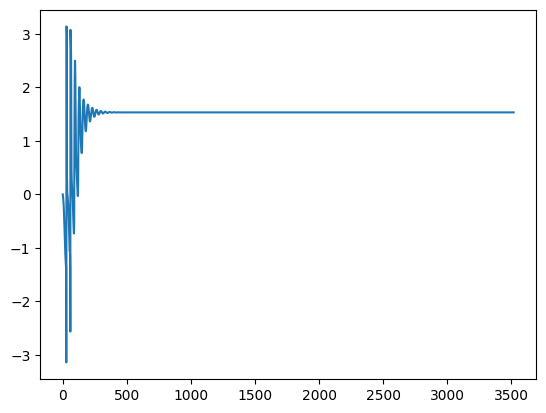

In [124]:
plt.plot(to_theta(np.angle(np.fft.fft(X, axis=1)[:, 1])[1:] - np.angle(np.fft.fft(DX, axis=1)[:, 1])))

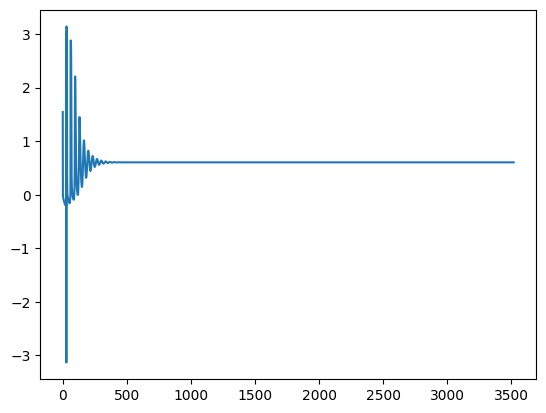

In [125]:
plt.plot(to_theta(np.angle(np.fft.fft(X, axis=1)[:, 1])[:-1] - np.angle(np.fft.fft(DX + dt*alpha*X[:-1], axis=1)[:, 1])))

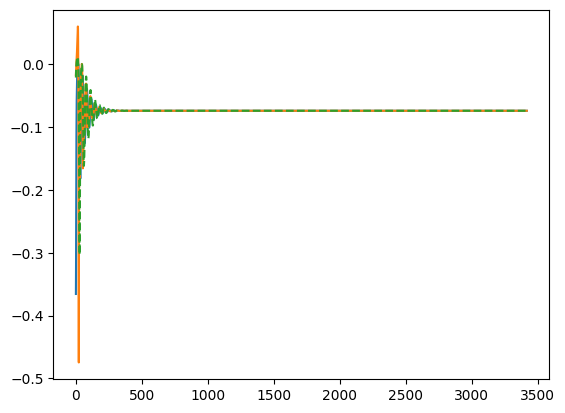

In [126]:
plt.plot(to_theta(np.angle(np.fft.fft(X[1:], axis=1)[:, 1]) - np.angle(np.fft.fft(X[:-1], axis=1)[:, 1]))[100:])
plt.plot(to_theta(np.angle(np.fft.fft(DX[1:], axis=1)[:, 1]) - np.angle(np.fft.fft(DX[:-1], axis=1)[:, 1]))[99:])
plt.plot(to_theta(np.angle(np.fft.fft((DX + dt*alpha*X[:-1])[1:], axis=1)[:, 1]) - np.angle(np.fft.fft((DX + dt*alpha*X[:-1])[:-1], axis=1)[:, 1]))[99:], linestyle='dashed')

In [26]:
tau_x = 1 / 100
alpha = 1 / tau_x
ks1 = []
das1 = []
for tau_a in np.linspace(T/6, T/2, 15):
    delay_i = round(tau_a / dt)
    (
        X, w, W, DW, DX
    ) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_.copy(),
                 get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
                 train=False, full_info=True, init_stimulation=True)
    k = infer_frequencies(X[:, 0])[-1]
    ks1.append(k)
    da = np.angle(np.fft.fft(X[-1])[1]) - np.angle(np.fft.fft(DX[-1])[1])
    das1.append(da)

In [27]:
tau_x = 1 / 200
alpha = 1 / tau_x
ks2 = []
das2 = []
for tau_a in np.linspace(T/6, T/2, 15):
    delay_i = round(tau_a / dt)
    (
        X, w, W, DW, DX
    ) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_.copy(),
                 get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
                 train=False, full_info=True, init_stimulation=True)
    k = infer_frequencies(X[:, 0])[-1]
    ks2.append(k)
    da = np.angle(np.fft.fft(X[-1])[1]) - np.angle(np.fft.fft(DX[-1])[1])
    das2.append(da)

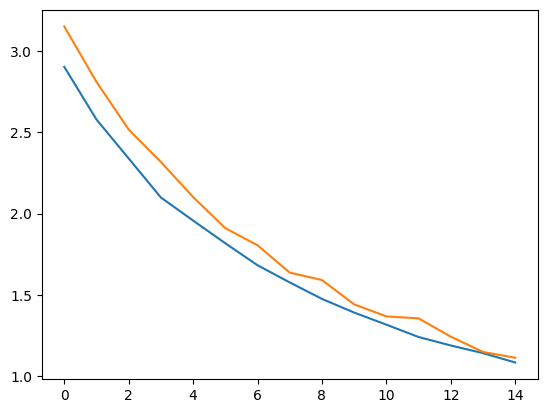

In [28]:
plt.plot(ks1)
plt.plot(ks2)

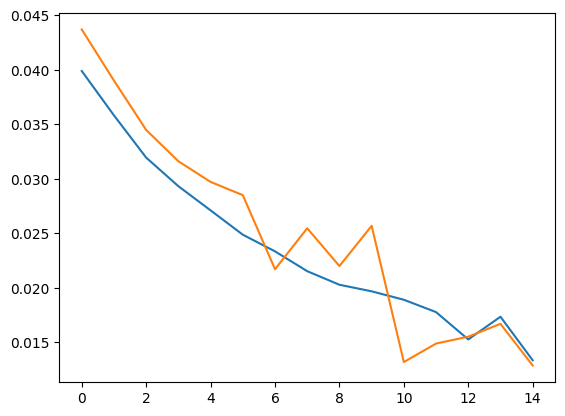

In [33]:
plt.plot(to_theta(np.array(das1)) + np.pi/2)
plt.plot(to_theta(np.array(das2)) + np.pi/2)

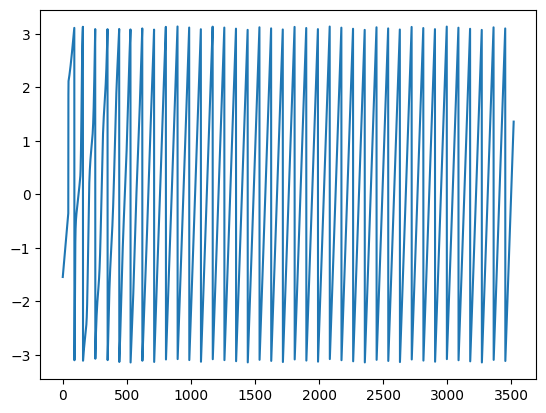

In [64]:
plt.plot(np.angle(np.fft.fft(DX + dt*alpha*X[:-1], axis=1)[:, 1]))

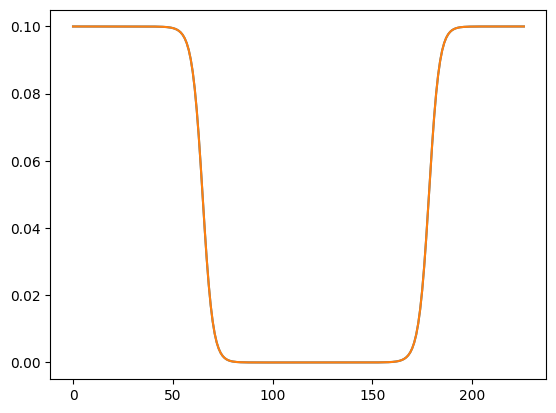

In [58]:
plt.plot((DX + dt*alpha*X[:-1])[300])
plt.plot(phi(f_I_conv_circ_fft(w, X[301 - delay_i]))*dt*alpha)
#plt.plot((X[1:])[:300, 27], linestyle='dashed')

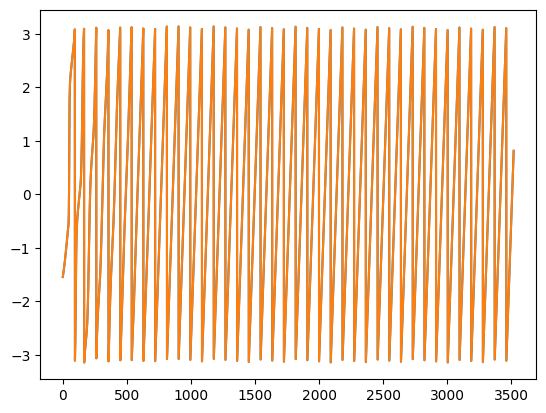

In [23]:
plt.plot(np.angle(np.fft.fft(X, axis=1)[:, 1][1:]))
plt.plot(np.angle(np.fft.fft(DX + X[:-1], axis=1)[:, 1]))

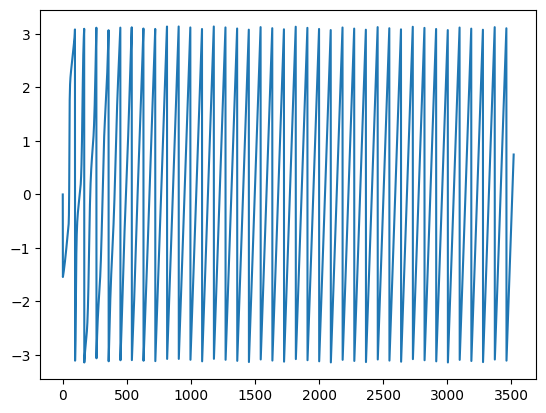

In [15]:
plt.plot(to_theta(np.angle(np.fft.fft(X, axis=1)[:, 1][1:] - np.fft.fft(DX, axis=1)[:, 1])))

In [89]:
freqs = np.fft.fftfreq(N)
x_fft = np.fft.fft(X[-1])
x_interp_fft = np.fft.fft((X[-1]+X[-2])/2)
x_delay_fft = np.fft.fft(X[-1-delay_i])

TODO:
- plot frequency vs delay over different tau_x
- plot (angle x - angle dx) vs delay over different tau_x

prediction:
- shorter delay ~ higher frequency

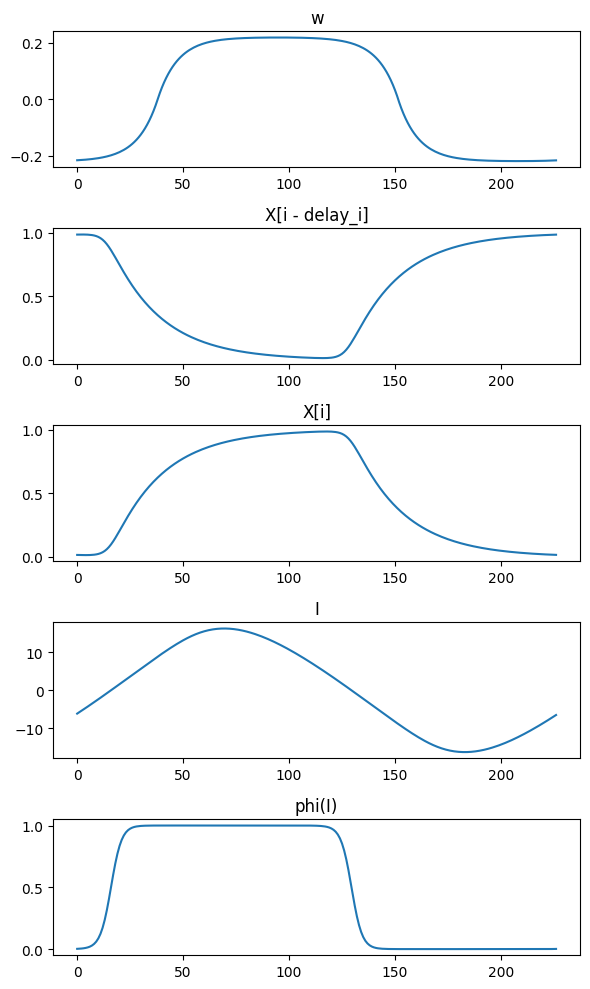

In [90]:
i = -50
plt.figure(figsize=(6, 10))
plt.subplot(511)
plt.plot(w)
plt.title('w')
plt.subplot(512)
plt.plot(X[i - delay_i])
plt.title('X[i - delay_i]')
plt.subplot(513)
plt.plot(X[i])
plt.title('X[i]')
plt.subplot(514)
plt.plot((f_I_conv_circ_fft(w, X[i - delay_i])))
plt.title('I')
plt.subplot(515)
plt.plot(phi(f_I_conv_circ_fft(w, X[i - delay_i])))
plt.title('phi(I)')
plt.tight_layout()

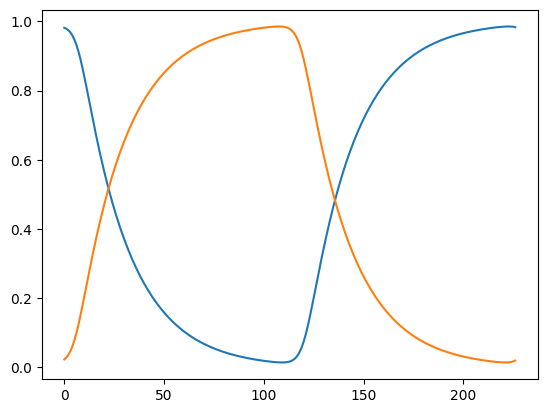

In [91]:
plt.plot(X[-1])
plt.plot(X[-1-delay_i])

In [92]:
get_angle(X[-1]), get_angle(X[-1-delay_i])

(0.815576033527393, -2.281248682693135)

In [93]:
get_angle(phi(f_I_conv_circ_fft(w, X[-1 - delay_i])))

1.3603714914385374

In [94]:
np.angle(np.fft.fft(w)[1]*np.fft.fft(X[-1-delay_i])[1])

1.3793297817057217

In [97]:
to_theta(get_angle(w) + get_angle(X[-1-delay_i]))

1.3793297817057217

In [96]:
k = infer_frequencies(X[:, 0])[-1]

In [98]:
to_theta(get_angle(w) + get_angle(X[-1]) + np.angle(np.exp(-2*np.pi*1j*k*freqs[1]*(delay_i))))

1.4031341605457683

In [123]:
get_angle(X[-100])

0.28574695958902235

In [122]:
get_angle(DX[-99])

1.8909524643693183

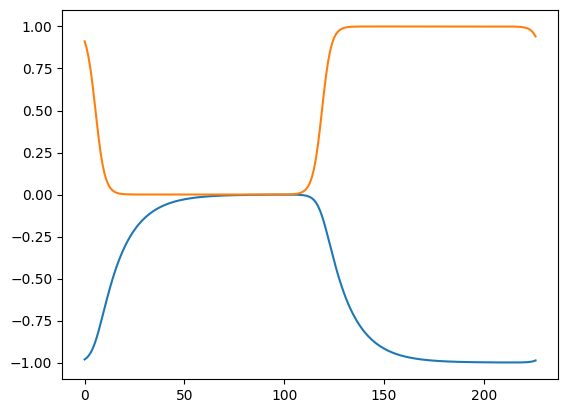

In [16]:
plt.plot(-X[-1])
plt.plot(phi(f_I_conv_circ_fft(w, X[-1 - delay_i])))

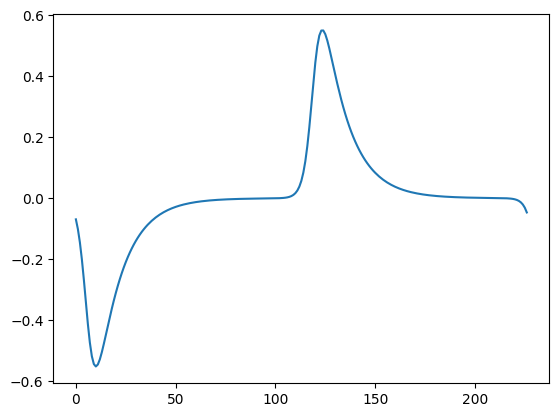

In [17]:
plt.plot(phi(f_I_conv_circ_fft(w, X[-1 - delay_i]))-X[-1])

In [18]:
get_angle(-X[-1]), get_angle(phi(f_I_conv_circ_fft(w, X[-1 - delay_i])))

(-2.036266672342188, 1.4204661345072052)

In [19]:
get_angle(-X[-1] + phi(f_I_conv_circ_fft(w, X[-1 - delay_i])))

2.657730444637038

In [20]:
get_angle(-X[-1]) + get_angle(phi(f_I_conv_circ_fft(w, X[-1 - delay_i])))

-0.6158005378349829

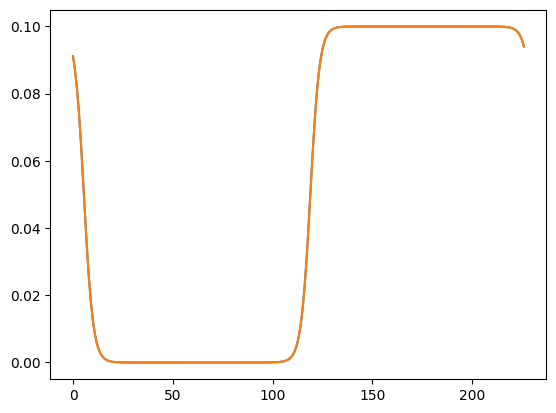

In [35]:
plt.plot(DX[-1] + dt*alpha*X[-2])
plt.plot(dt*alpha*phi(f_I_conv_circ_fft(w, X[-1 - delay_i])))

In [28]:
np.angle(np.exp(1j*get_angle(-X[-1])) + np.exp(1j*get_angle(phi(f_I_conv_circ_fft(w, X[-1 - delay_i])))))

2.833692384672302

In [ ]:
plt.plot(get_angles(X[delay_i:]))
plt.plot([
    get_angle(f_I_conv_circ_fft(w, X[i - delay_i]))
    for i in range(delay_i, len(t))
])

In [ ]:
plt.plot(np.abs(np.fft.fft(X, axis=1)[:, 1]))
plt.plot([
    np.abs(np.fft.fft(phi(f_I_conv_circ_fft(w, X[i - delay_i])))[1])
    for i in range(delay_i, len(t))
])

### calculating angle of dr

$$
    \theta_{\dot{r}} = \text{arg}\Big(-\mathcal{F}_{x}[r]\Big(\xi=\frac{1}{T}, t\Big) + \mathcal{F}_x[w(x, t)*{r}(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$
$$
    = \text{arg}\Big(e^{-i\theta_r} + \mathcal{F}_x[w(x, t)*{r}(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$

1.1851901698050842

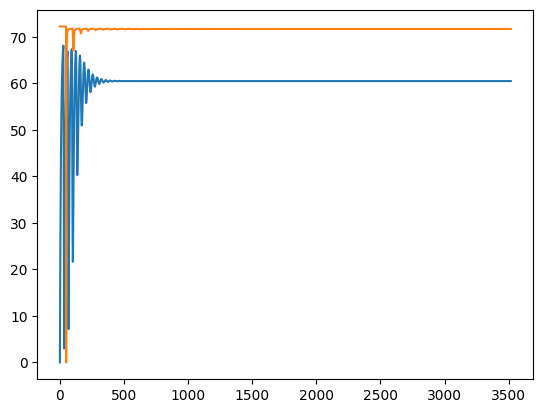

In [127]:
plt.plot(get_amps(-X[:-1]))
plt.plot(get_amps(I))
C_amp = get_amps(I)[-1] / get_amps(-X[:-1])[-1]
C_amp

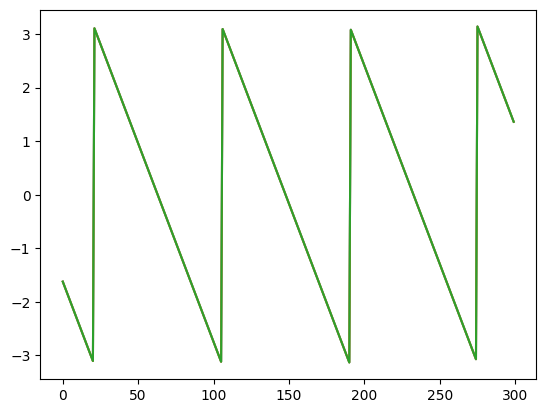

In [128]:
I = DX/dt/alpha + X[:-1]
plt.plot(np.angle(np.exp(1j*get_angles(-X[:-1])) + C_amp * np.exp(1j*get_angles(I)))[-300:])
plt.plot(get_angles(-X[:-1] + I)[-300:])
plt.plot(get_angles(DX)[-300:])

### theta step 1

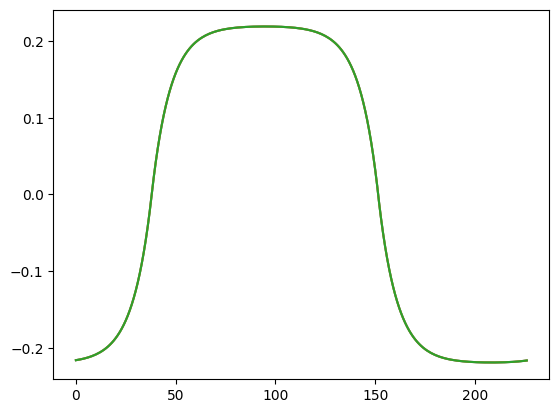

In [7]:
plt.plot(W[::1000].T);

Text(0.5, 0, 'time (s)')

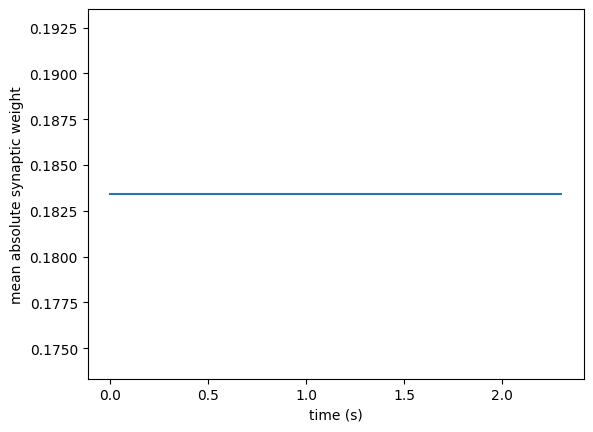

In [8]:
plt.plot(t[::100], np.abs(W[::100]).mean(1))
plt.ylabel("mean absolute synaptic weight")
plt.xlabel(f"time (s)")

$$
\theta_{w}(t) = \text{arg}\Big(\mathcal{F}_{\Delta x}[w]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$

$$
\dot{\theta}_w = \frac{d}{dt} \text{arg}\Big(\mathcal{F}_{\Delta x}[w]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$
THIS DOESN'T HOLD IN GENERAL!
$$= \frac{d}{dt}\Big(\text{arg}(-i) + \text{arg}\Big(\mathcal{F}_{\Delta x}\Big[\frac{\partial w}{\partial t}\Big]\Big(\xi=\frac{1}{T}, t\Big)\Big)\Big)
$$
$$
= \frac{d}{dt}\Big(\text{arg}\Big(\mathcal{F}_{\Delta x}\Big[\frac{\partial w}{\partial t}\Big]\Big(\xi=\frac{1}{T}, t\Big)\Big)\Big)
$$

### theta step 2

$$
\text{arg}\Big(\mathcal{F}_{\Delta x}[\dot{r}(x, t) *' r(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)\Big)
$$
$$
= \text{arg}\Bigg(\mathcal{F}_{x}[\dot{r}(x, t)]\Big(\xi=\frac{1}{T}, t\Big)\overline{\mathcal{F}_{x}[r(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)}\Bigg)
$$
$$
= \text{arg}\Bigg(\mathcal{F}_{x}[\dot{r}(x, t)]\Big(\xi=\frac{1}{T}, t\Big)\Bigg) + \text{arg}\Bigg(\overline{\mathcal{F}_{x}[r(x, t-\tau_d)]\Big(\xi=\frac{1}{T}, t\Big)}\Bigg)
$$

Time scaling rule: if $r(x, t=t')_{[0, T]} = r(x=x', kt)_{[0, T]}$, then
$$
\mathcal{F}_{x}[r(y, t=t')_{[0, T]}](\xi) = \mathcal{F}_{t}[r(x=x', ky)_{[0, T]}](\xi)
$$
$$
= \frac{1}{k}\mathcal{F}_{t}[r(x=x', y)_{[0, T]}]\Big(\frac{\xi}{k}\Big)
$$
In code: ignore scaling factor 1/k

$$
= \text{arg}\Bigg(\mathcal{F}_{t}[\dot{r}(0, \omega t')_{[t, t+T]}]\Big(\xi=\frac{1}{T}, t\Big)\Bigg) + \text{arg}\Bigg(\overline{\mathcal{F}_{t}[r(0, \omega(t'-\tau_d))_{[t, t+T]}]\Big(\xi=\frac{1}{T}, t\Big)}\Bigg)
$$

$$
= \text{arg}\Bigg(2 \pi i \frac{\omega}{T} \mathcal{F}_{t}[{r}(0, \omega t')_{[t, t+T]}]\Big(\xi=\frac{1}{T}, t\Big)\Bigg) + \text{arg}\Bigg(\overline{e^{-2\pi i \frac{\omega\tau_d}{T}}}\overline{\mathcal{F}_{t}[r(0, \omega t')_{[t, t+T]}]\Big(\xi=\frac{1}{T}, t\Big)}\Bigg)
$$

$$
= \text{arg}(i) + \text{arg}\Bigg(\mathcal{F}_{t}[{r}(0, \omega t')_{[t, t+T]}]\Big(\xi=\frac{1}{T}, t\Big)\Bigg) -
\text{arg}(e^{-2\pi i \frac{\omega\tau_d}{T}}) - \text{arg}\Bigg(\mathcal{F}_{t}[r(0, \omega t')_{[t, t+T]}]\Big(\xi=\frac{1}{T}, t\Big)\Bigg)
$$

$$
= \text{arg}(i) - \text{arg}(e^{-2\pi i \frac{\omega\tau_d}{T}})
$$

### big insight 1: we can predict the macro behaviour of the system based on $\tau_r$, $\text{arg}(e^{-2\pi i \frac{\omega\tau_d}{T}})$ and $\lambda$:

for $\lambda = 20$ and $\tau_x = 0.01$:

quadrant 4 "(+a-bi)" (irrelevant): flips between forward and reverse replay, $\sim \tau_d < T/10$

quadrant 3 "(-a-bi)" (irrelevant): reverse replay, $\sim T/5 > \tau_d > T/10$

quadrant 2 "(-a+bi)" (irrelevant): forward replay, $\sim T/3.3 > \tau_d > T/5$

quadrant 1 "(+a+bi)" (irrelevant): forward replay, $\sim \tau_d > T/3.3$

for $\lambda = 40$, $\tau_d$ needs to be smaller for the same phases

In [8]:
(np.exp(-2 * np.pi * 1j * 2.5 * (T/3.3)/T))

(0.04758191582374238+0.998867339183008j)

### theta step 3

we have to make an argument about the role of the decay term

$$
\frac{d}{dt}\Big(\text{arg}\Big(\mathcal{F}_{\Delta x}\Big[\frac{\partial w}{\partial t}\Big]\Big(\xi=\frac{1}{T}, t\Big)\Big)\Big)
\approx \frac{d}{dt} \Big(\text{arg}(e^{-2\pi i \frac{\omega(t)\tau_d}{T}})\Big)
$$

- $\varphi$ preserves phase of first fourier component
- phase gets shifted by multiplication by $e^{-2\pi i \xi\Delta\theta}$
- phase gets shifted by 90 degrees through differentiation

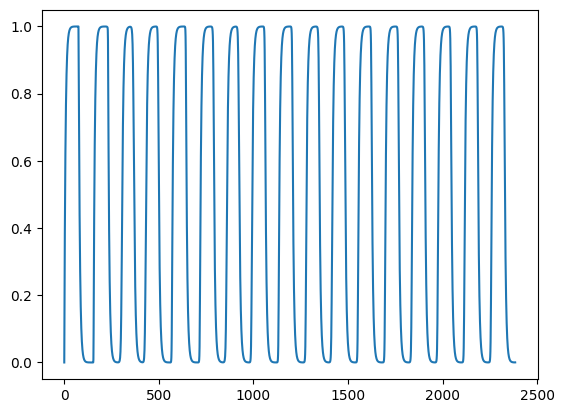

In [61]:
plt.plot(X[:, 0])

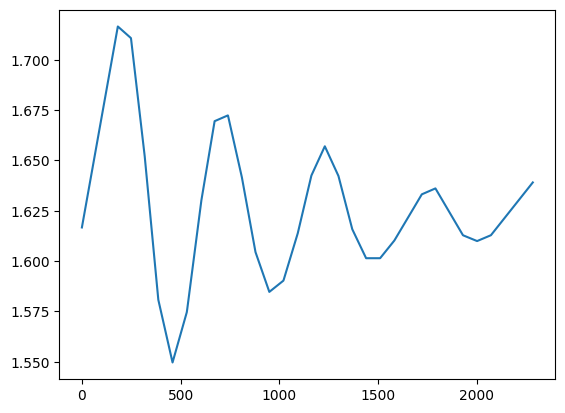

In [66]:
plt.plot(infer_frequencies(X[:, 0])[100:])

In [76]:
i = 2000

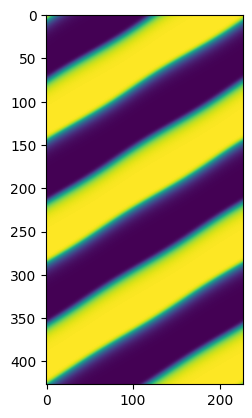

In [77]:
plt.imshow(X[i-100:i+N+100])

In [78]:
k = infer_frequencies(X[:, 0])[i]
k

1.617742439982938

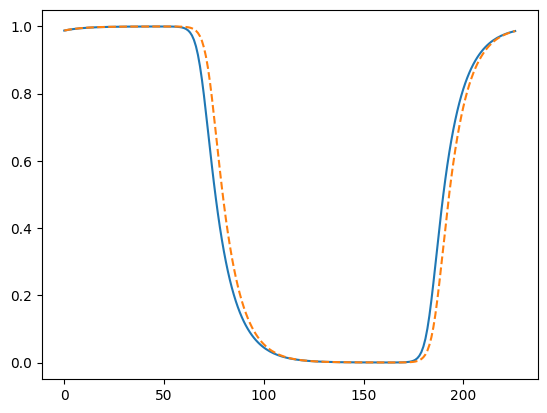

In [79]:
plt.plot(zoom(X[i:i+N][:, 0], k)[:N])
#plt.twiny()
plt.plot(X[i:i+N][0], linestyle='dashed')

In [80]:
dx_t = np.fft.fft(zoom(DX[i:i+N, 0], k)[:N])
dx_x = np.fft.fft(DX[i])
approx_dx_t = 2*np.pi*1j*freqs*k*np.fft.fft(zoom(X[i:i+N, 0], k)[:N])
approx_dx_x = 2*np.pi*1j*freqs*k*np.fft.fft(X[i])

xd_x = np.fft.fft(X[i-delay_i])
xd_t = np.fft.fft(zoom(X[i-delay_i:i-delay_i+N, 0], k)[:N])
approx_xd_t = np.exp(-2*np.pi*1j*k*freqs*(delay_i)) * np.fft.fft(zoom(X[i:i+N, 0], k)[:N])

x_x = np.fft.fft(X[i])
x_t = np.fft.fft(zoom(X[i:i+N, 0], k)[:N])

In [81]:
(
    np.angle(dx_x * np.conj(xd_x))[1],
    np.angle(np.fft.fft((DX[i][rolling_indices] * X[i-delay_i][:, None]).sum(0)))[1],
    (
        np.angle(dx_x) +
        np.angle(np.conj(xd_x))
    )[1],
    (
        np.angle(dx_t) +
        np.angle(np.conj(xd_t))
    )[1],
    (
        np.angle(approx_dx_t) +
        np.angle(np.conj(approx_xd_t))
    )[1],
    to_theta(np.angle(1j) - np.angle(np.exp(-2*np.pi*1j*k*freqs[1]*(delay_i))))
)

(-1.2630912980769473,
 -1.2630912980769473,
 -1.2630912980769473,
 -1.287468239348996,
 -1.3092711818942688,
 -1.3092711818942693)

In [82]:
c1 = np.abs(-100 * dt * np.fft.fft(W, axis=1)[:, 1]).mean()/100
c2 = np.abs([
        np.fft.fft((DX[j-1][rolling_indices] * X[j - delay_i][:, None]).mean(0))[1]
        for j in range(len(t)//2, len(t))
    ]).mean()
c1*lmbda, c2

(0.5954806772169605, 0.9465906424523328)

In [83]:
W_fft = np.fft.fft(W, axis=1)[:, 1]
DW_fft = np.fft.fft(DW, axis=1)[:, 1]
D_W_fft = W_fft[1:] - W_fft[:-1]
theta_W = np.angle(W_fft)
theta_DW = np.angle(DW_fft)
theta_D_W = np.angle(D_W_fft)
#(freqs[1] * delay_i) ~ (tau_a / T)
approx_theta_DW = to_theta(
        mean_angle(
            [c2, c1*lmbda],
            [np.angle(1j) -
             np.angle(
                 np.exp(
                     -2*np.pi*1j*infer_frequencies(X[1:, 0])
                     *freqs[1]*(delay_i)
                 )
             ),
             np.angle(np.fft.fft(-W, axis=1)[:, 1])
            ]
        )
    )
approx_theta_DW2 = to_theta(
    np.angle(1j) -
    np.angle(
        np.exp(
            -2*np.pi*1j*infer_frequencies(X[1:, 0])
            *freqs[1]*(delay_i)
        )
    )
)
approx_theta_W = approx_theta_DW - np.angle(1j)

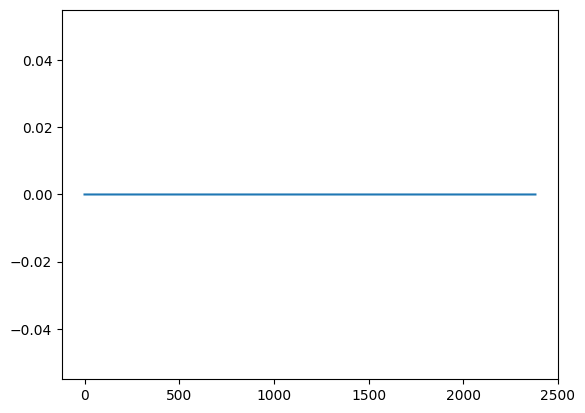

In [75]:
plt.plot(to_theta(theta_W[1:] - theta_W[:-1]))

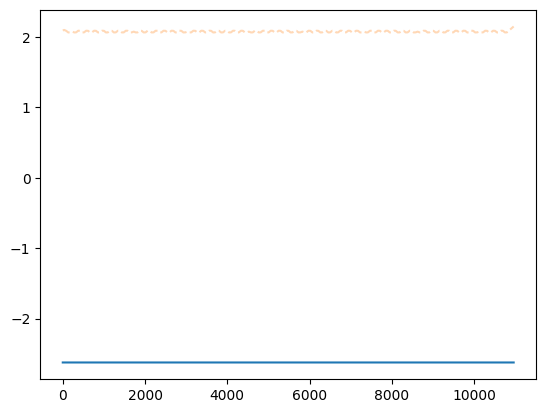

In [25]:
plt.plot(theta_W[500:])
#plt.plot(to_theta(theta_DW - np.angle(1j))[500:], linestyle='dashed', alpha=0.3)
plt.plot(to_theta(approx_theta_DW - np.angle(1j))[500:], linestyle='dashed', alpha=0.3)

In [135]:
hebb = DW + lmbda * dt * beta * W

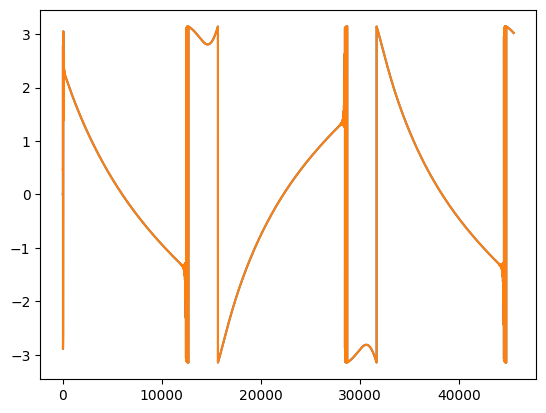

In [136]:
plt.plot(np.angle(tau_w * DW_fft))
plt.plot(
    np.angle(
        -lmbda * dt * W_fft
        + tau_w * np.fft.fft(hebb)[:, 1]
    )
)

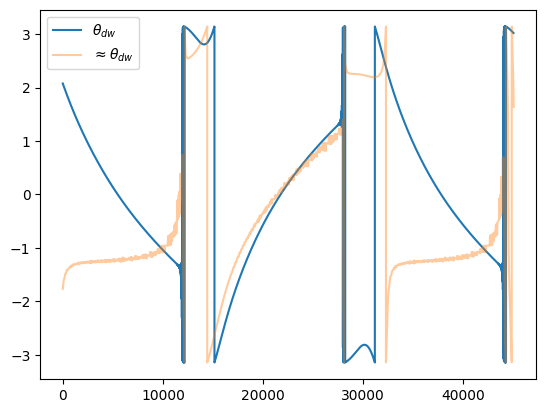

In [137]:
#plt.plot(np.angle(np.fft.fft(W, axis=1)[delay_i:, 1]), label=r'$\theta_w$')
plt.plot(np.angle(DW_fft[delay_i:])[500:], label=r'$\theta_{dw}$')
plt.plot(approx_theta_DW[500:], label=r'$\approx \theta_{dw}$', alpha=0.4)
#plt.plot(to_theta(approx_theta_DW2[500:] + np.angle(np.exp(0.6j))), label=r'$\approx \theta_{dw}$')
plt.legend()

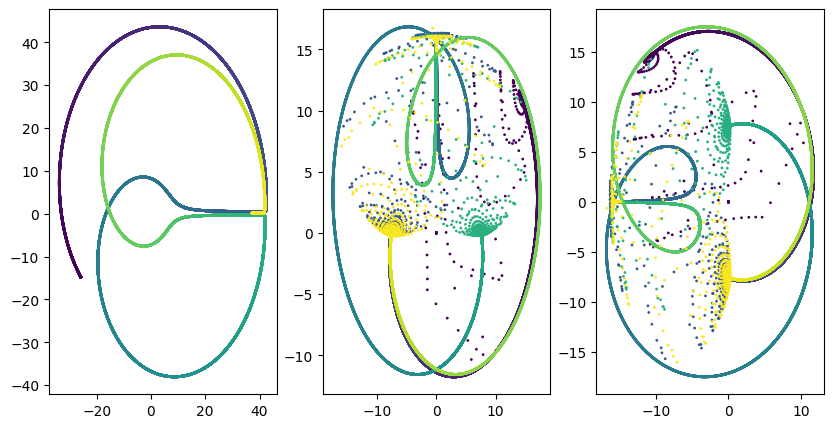

In [51]:
plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.scatter(W_fft.real, W_fft.imag, c=t[1:], s=1)
#plt.colorbar()
#plt.ylim(-30, 30)
#plt.xlim(-30, 30)
plt.subplot(132)
plt.scatter((-1j*DW_fft).real/dt, (-1j*DW_fft).imag/dt, c=t[1:], s=1)
#plt.xlim(-20, 20)
#plt.ylim(-20, 20)
#plt.colorbar()
plt.subplot(133)
plt.scatter((DW_fft).real/dt, (DW_fft).imag/dt, c=t[1:], s=1)

(2.289344042526255, 0.9017038898384274, 0.9020966800703706)

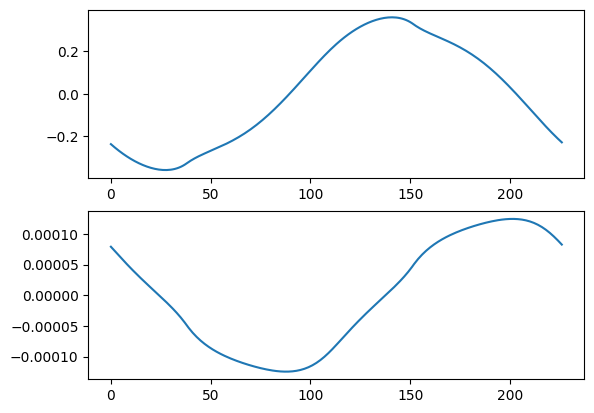

In [46]:
plt.subplot(211)
plt.plot(W[3000])
plt.subplot(212)
plt.plot(DW[3000])
np.angle(W_fft[3000]), np.angle(D_W_fft[3000]), np.angle(DW_fft[3000])

(0.0, 0.0018302393064453693)

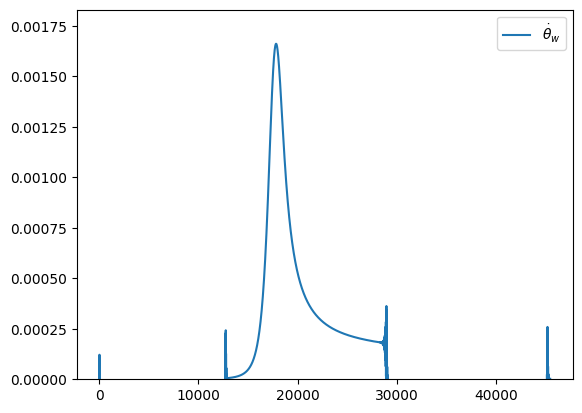

In [47]:
plt.plot(to_theta(
            np.angle(np.fft.fft(W, axis=1)[1:, 1]) -
            np.angle(np.fft.fft(W, axis=1)[:-1, 1])
         )[delay_i:],
         label=r'$\dot{\theta}_w$')
plt.legend()
plt.ylim(bottom=0)

### amplitude of hebb and reg

In [219]:
c1*lmbda

0.6112669178858183

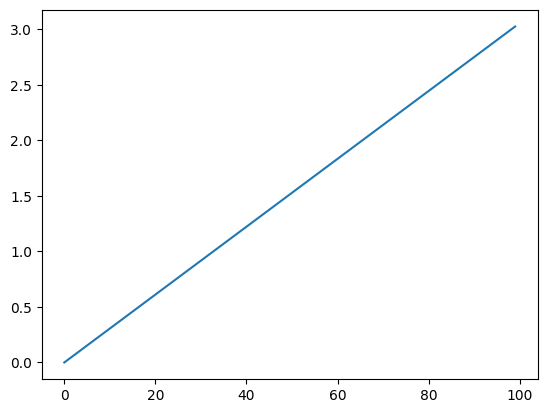

In [220]:
plt.plot([np.abs(-l * dt * np.fft.fft(W, axis=1)[:, 1]).mean()
          for l in range(100)])

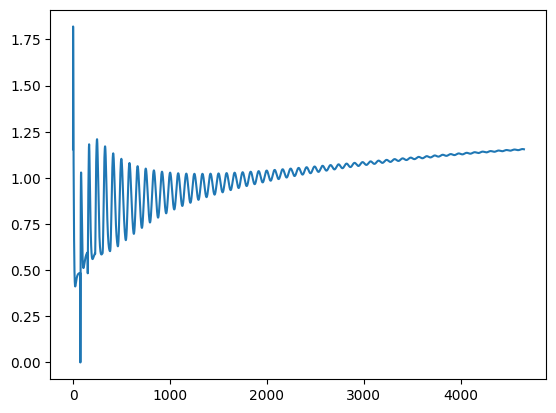

In [247]:
plt.plot(np.abs([
    np.fft.fft((DX[j-1][rolling_indices] * X[j - delay_i][:, None]).mean(0))[1]
    for j in range(len(t))
]))

In [223]:
start = 1000
end = 4500

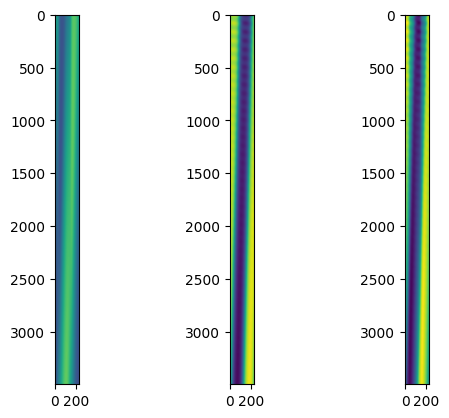

In [224]:
plt.subplot(131)
plt.imshow([
    -lmbda * w * dt * beta
    for w in W[start:end]
], vmin=-0.0002, vmax=0.0002)
plt.subplot(132)
plt.imshow([
    beta * (DX[j-1][rolling_indices] * X[j - delay_i][:, None]).mean(0)
    for j in range(start, end)
], vmin=-0.0002, vmax=0.0002)
plt.subplot(133)
plt.imshow(DW[start:end])

In [20]:
a = 0.5 + 0.5j
b = 5 * (-1 - 0.01j)
np.angle(a + b), np.angle(a), np.angle(b)

(3.0419240010986313, 0.7853981633974483, -3.131592986903128)

In [22]:
mean_angle([np.abs(a), np.abs(b)], [np.angle(a), np.angle(b)])

3.0419240010986313

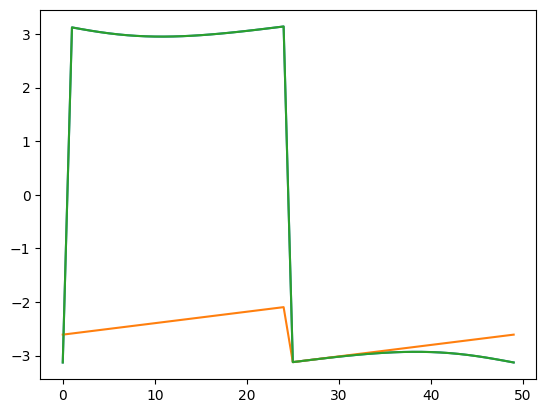

In [23]:
plt.plot([
    np.angle(b + np.exp(2*np.pi*1j*i))
    for i in np.linspace(0, 1)
])
plt.plot([
    np.abs(b)*np.angle(b)/(1+np.abs(b)) + np.angle(np.exp(2*np.pi*1j*i))/(1+np.abs(b))
    for i in np.linspace(0, 1)
])
plt.plot([
    mean_angle([np.abs(b), 1], [np.angle(b), np.angle(np.exp(2*np.pi*1j*i))])
    for i in np.linspace(0, 1)
])

In [37]:
s = np.abs(a) + np.abs(b)

In [38]:
np.abs(a)/s * np.angle(a) + np.abs(b)/s * np.angle(b)

-0.9283620480028578

### pathological/degenerate solutions: limit cycle of synchronized maximum activity through k populations

In [28]:
simulation_duration = 5000.5 * T
t = np.arange(0, simulation_duration, dt)

lmbda = 20

In [31]:
(
    X_dream2,
    w_dream2,
    W_dream2,
) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_full.copy(),
             get_dw, get_dx, f_I_matrix_multiply, phi, u,
             train=False, full_info=False)

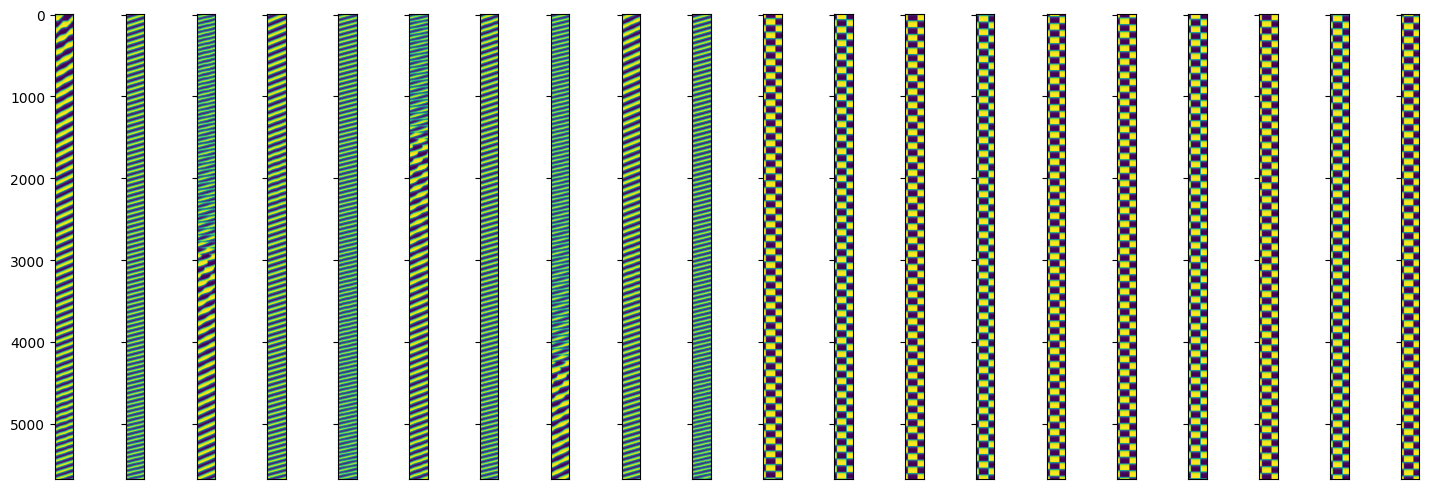

In [32]:
plot_activity(X_dream2, cutoff_div=20)

Text(0.5, 0, 'time (s)')

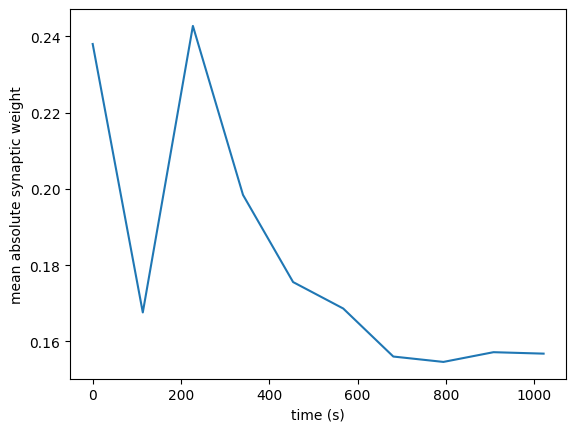

In [33]:
plt.plot(t[::math.ceil(len(t)/10)], np.abs(W_dream2).mean((1, 2)))
plt.ylabel("mean absolute synaptic weight")
plt.xlabel(f"time (s)")

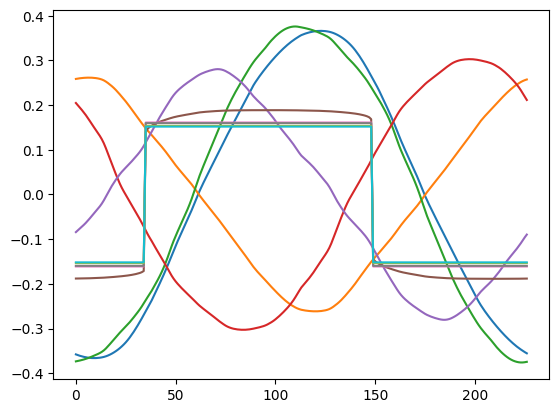

In [34]:
plt.plot(W_dream2[:, :, 0].T);

weight matrix not circulant, can't simplify!

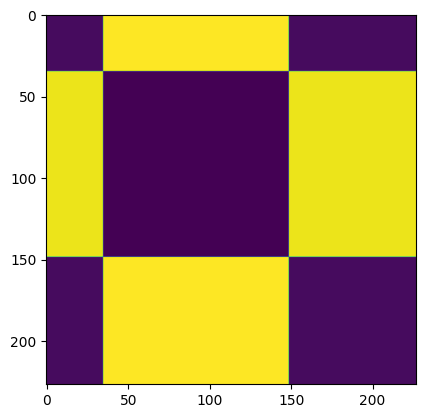

In [42]:
plt.imshow(w_dream2)

### dictionary of pathological behaviour

short delay: direction flipping

In [283]:
simulation_duration = 250.5 * T
t = np.arange(0, simulation_duration, dt)

lmbda = 20

tau_x = 1 / 100
alpha = 1 / tau_x

tau_a = T / 10
delay_i = round(tau_a / dt)

In [284]:
%%time
(
    X_dream1,
    w_dream1,
    W_dream1,
) = simulate(dt, N, T, t, theta, alpha, beta, delay_i, lmbda, w_.copy(),
             get_dw_prime_mean, get_dx, f_I_conv_circ_fft, phi, u,
             train=False, full_info=False)

CPU times: user 11.9 s, sys: 12.9 ms, total: 11.9 s
Wall time: 12 s


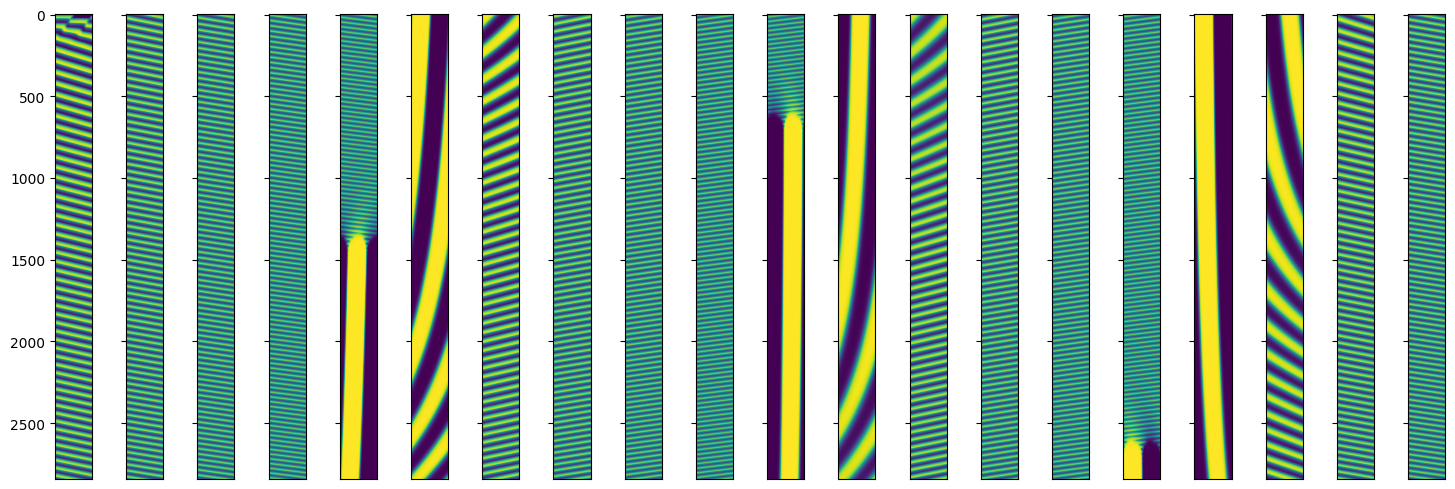

In [285]:
plot_activity(X_dream1, cutoff_div=None)